## Dimensions
1. Number of clusters (3,5,7,9)
2. Cluster validity index (DBIndex, Silhoutte Index, Dunn Index)
3. Algorithms (Genetic, Particle Swarm, Particle Gray Wolf)
4. Datasets (BBC, BBC Sports, Reuters, 20 newsgroup, etc.)

In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Time to pre-process : 5.078125
[[ 0.74551217 -0.37969668 -0.54776092]
 [ 0.88827166 -0.05541459 -0.45596346]
 [ 0.83940491 -0.01641803 -0.54325855]
 ...
 [ 0.90881336 -0.12560209 -0.3978472 ]
 [ 0.89388821  0.05436093 -0.44498176]
 [ 0.8512689  -0.50202723  0.15267587]]


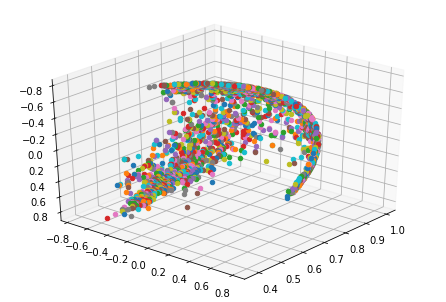

In [2]:
all_texts=[]
Y = []
dictionary= {}
start = time.process_time()
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GA")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process : "+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    temp = ' '.join(map(str, X[j]))
    dictionary[temp]=Y[j]
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 140)

In [3]:
K=7
P=30
cross_over_rate=0.1
mutation_rate=0.01
number_of_generations=100

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

Cluster purity measure indexes

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(chromsome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [18]:
def supervised_scores(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    
    Y_actual=[]
    Y_pred=[]
    for i in range(K):
        t=[]
        for j in range(len(clusters[i])):
            temp = ' '.join(map(str, clusters[i][j]))
            Y_actual.append(dictionary[temp])
            t.append(dictionary[temp])
        print(t)
        pred = statistics.mode(t)
        print(pred)
        for j in range(len(clusters[i])):
            Y_pred.append(pred)
            
    print(confusion_matrix(Y_actual, Y_pred))
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    start = time.process_time()
    population = population_initialization()
    gen=0
    return_chromosome=[]
    gen_fitness = []
    for i in range(number_of_generations):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
        temp = []
        temp.append(str(gen))
        temp.append(str(max(fitness)))
        gen_fitness.append(temp)
        print("Generation: "+str(gen)+" | Best fitness: "+str(max(fitness)))
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GA with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return population[fitness.index(max(fitness))]

In [20]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#99ddff','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Best fitness: 9.922634597355227
Generation: 2 | Best fitness: 8.721679836469828
Generation: 3 | Best fitness: 10.135973525433439
Generation: 4 | Best fitness: 11.483405083254542
Generation: 5 | Best fitness: 7.433716163728004
Generation: 6 | Best fitness: 9.96158883914422
Generation: 7 | Best fitness: 9.21846019249455
Generation: 8 | Best fitness: 9.218460192494558
Generation: 9 | Best fitness: 9.174135146195898
Generation: 10 | Best fitness: 8.197799109571092
Generation: 11 | Best fitness: 7.994990736513133
Generation: 12 | Best fitness: 8.998902716926136
Generation: 13 | Best fitness: 8.457986293916528
Generation: 14 | Best fitness: 12.237205089853648
Generation: 15 | Best fitness: 9.086208924759156
Generation: 16 | Best fitness: 9.314037061321628
Generation: 17 | Best fitness: 9.938167935920644
Generation: 18 | Best fitness: 9.938167935920642
Generation: 19 | Best fitness: 8.374464721423571
Generation: 20 | Best fitness: 9.068828676810295
Generation: 21 | Best fitnes

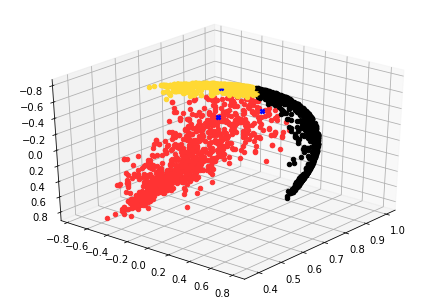

In [26]:
K = 3
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 23.369068818766948
Generation: 2 | Best fitness: 23.696613202233067
Generation: 3 | Best fitness: 23.97205875132135
Generation: 4 | Best fitness: 26.126961963165222
Generation: 5 | Best fitness: 24.566420142999306
Generation: 6 | Best fitness: 24.566420142999302
Generation: 7 | Best fitness: 22.36852427476539
Generation: 8 | Best fitness: 22.3685242747654
Generation: 9 | Best fitness: 24.43963994967161
Generation: 10 | Best fitness: 24.247263385384006
Generation: 11 | Best fitness: 16.647510564326062
Generation: 12 | Best fitness: 18.732611430525036
Generation: 13 | Best fitness: 26.830453548450947
Generation: 14 | Best fitness: 21.35663948088367
Generation: 15 | Best fitness: 26.98157498019962
Generation: 16 | Best fitness: 26.981574980199728
Generation: 17 | Best fitness: 25.840464265494422
Generation: 18 | Best fitness: 21.30562970448989
Generation: 19 | Best fitness: 23.65120477529533
Generation: 20 | Best fitness: 17.278248600944856
Generation: 21 | B

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 76 | Best fitness: 13.681977247273228
Generation: 77 | Best fitness: 13.222099188761284
Generation: 78 | Best fitness: 12.693489372092552
Generation: 79 | Best fitness: 12.660007739784117
Generation: 80 | Best fitness: 12.660007739784083
Generation: 81 | Best fitness: 11.320729595939627
Generation: 82 | Best fitness: 11.32072959593958
Generation: 83 | Best fitness: 11.255631686358274
Generation: 84 | Best fitness: 11.218437059427263
Generation: 85 | Best fitness: 10.961068717846036
Generation: 86 | Best fitness: 10.912639216354037
Generation: 87 | Best fitness: 10.912639216353877
Generation: 88 | Best fitness: 10.797823996613747
Generation: 89 | Best fitness: 11.169716065519669
Generation: 90 | Best fitness: 11.169716065519685
Generation: 91 | Best fitness: 11.166286506393098
Generation: 92 | Best fitness: 11.191711806446223
Generation: 93 | Best fitness: 11.191711806446257
Generation: 94 | Best fitness: 11.166286506393245
Generation: 95 | Best fitness: 11.166286506393103
G

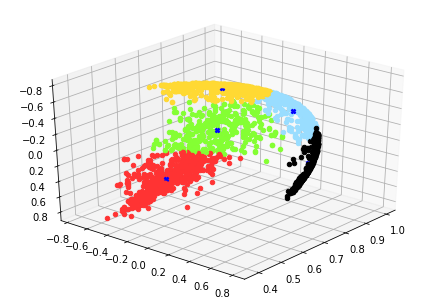

In [22]:
K = 5
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 42.679088505672475
Generation: 2 | Best fitness: 42.6790885056725


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 3 | Best fitness: 29.95734591860414
Generation: 4 | Best fitness: 42.059203262259416
Generation: 5 | Best fitness: 29.53789733609734
Generation: 6 | Best fitness: 33.36511378244369
Generation: 7 | Best fitness: 25.92137649147176
Generation: 8 | Best fitness: 30.502889536891395


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 9 | Best fitness: 33.34389958675781
Generation: 10 | Best fitness: 33.343899586757665
Generation: 11 | Best fitness: 26.671574931625997
Generation: 12 | Best fitness: 23.925915056905747
Generation: 13 | Best fitness: 28.102826387833968


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 14 | Best fitness: 28.102826387833968
Generation: 15 | Best fitness: 32.8762225046365
Generation: 16 | Best fitness: 32.876222504636694
Generation: 17 | Best fitness: 28.404186084456505
Generation: 18 | Best fitness: 29.949472194219762
Generation: 19 | Best fitness: 26.631597845528095
Generation: 20 | Best fitness: 26.631597845528617
Generation: 21 | Best fitness: 29.274793110522683
Generation: 22 | Best fitness: 29.274793110522683


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 23 | Best fitness: 24.140201093726667


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 24 | Best fitness: 33.50229980147148
Generation: 25 | Best fitness: 25.896793642928728
Generation: 26 | Best fitness: 36.57961651440678
Generation: 27 | Best fitness: 29.40073976162024
Generation: 28 | Best fitness: 27.275643452020006
Generation: 29 | Best fitness: 37.17599370669429
Generation: 30 | Best fitness: 37.175993706694236
Generation: 31 | Best fitness: 34.76687076057984
Generation: 32 | Best fitness: 25.29339513381693
Generation: 33 | Best fitness: 25.6311887901586
Generation: 34 | Best fitness: 38.97558964103869
Generation: 35 | Best fitness: 38.97558964103865
Generation: 36 | Best fitness: 39.66081883860705
Generation: 37 | Best fitness: 39.66081883860718
Generation: 38 | Best fitness: 25.440340425207765
Generation: 39 | Best fitness: 26.154499385038623
Generation: 40 | Best fitness: 26.154499385038406
Generation: 41 | Best fitness: 37.92372751811978
Generation: 42 | Best fitness: 37.923727518119726
Generation: 43 | Best fitness: 25.841205734053297
Generation: 4

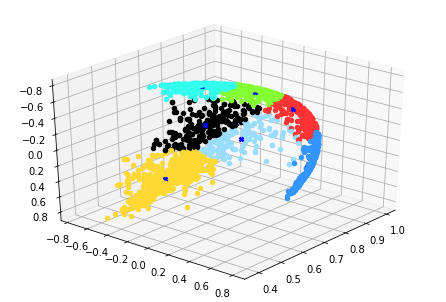

In [25]:
K = 7
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 40.33856740604013
Generation: 2 | Best fitness: 39.74008100529672
Generation: 3 | Best fitness: 51.35681715597337
Generation: 4 | Best fitness: 39.71160816951257
Generation: 5 | Best fitness: 42.34943738387712
Generation: 6 | Best fitness: 42.349437383877245
Generation: 7 | Best fitness: 37.13663814011115
Generation: 8 | Best fitness: 49.002570459340916
Generation: 9 | Best fitness: 50.937822651681515
Generation: 10 | Best fitness: 42.416049317969446
Generation: 11 | Best fitness: 42.694706862135476


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 12 | Best fitness: 42.69470686213503
Generation: 13 | Best fitness: 38.12868552324838
Generation: 14 | Best fitness: 37.65711375580293


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 15 | Best fitness: 37.634252660030405
Generation: 16 | Best fitness: 36.6460473723066
Generation: 17 | Best fitness: 36.1911297485069
Generation: 18 | Best fitness: 38.14140208843685
Generation: 19 | Best fitness: 43.30163723166445
Generation: 20 | Best fitness: 43.08533186506731
Generation: 21 | Best fitness: 42.08410215446532


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 22 | Best fitness: 38.13270080310166
Generation: 23 | Best fitness: 42.020146574007235
Generation: 24 | Best fitness: 39.79754169584099
Generation: 25 | Best fitness: 40.330948770811005
Generation: 26 | Best fitness: 39.48080914965443
Generation: 27 | Best fitness: 39.4808091496546
Generation: 28 | Best fitness: 37.827944731859944
Generation: 29 | Best fitness: 41.197960588723724
Generation: 30 | Best fitness: 40.991717232553746
Generation: 31 | Best fitness: 48.12081070634786
Generation: 32 | Best fitness: 38.29942407098582
Generation: 33 | Best fitness: 38.66949224431248
Generation: 34 | Best fitness: 43.10009227876496
Generation: 35 | Best fitness: 43.48224676263929
Generation: 36 | Best fitness: 43.48224676263965
Generation: 37 | Best fitness: 39.510313216756934
Generation: 38 | Best fitness: 39.51031321675702
Generation: 39 | Best fitness: 37.072756663770875
Generation: 40 | Best fitness: 37.07275666377079
Generation: 41 | Best fitness: 31.734228166655146
Generation: 4

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 82 | Best fitness: 29.09317670761353
Generation: 83 | Best fitness: 29.584020747715176
Generation: 84 | Best fitness: 31.355516424279006
Generation: 85 | Best fitness: 30.63628441271104
Generation: 86 | Best fitness: 30.610207877661484
Generation: 87 | Best fitness: 29.70431432570133
Generation: 88 | Best fitness: 29.382276016151692
Generation: 89 | Best fitness: 30.084189053284966
Generation: 90 | Best fitness: 30.08418905328506
Generation: 91 | Best fitness: 28.943843658373574
Generation: 92 | Best fitness: 30.760660197269026
Generation: 93 | Best fitness: 32.489933575765484
Generation: 94 | Best fitness: 29.915695044813
Generation: 95 | Best fitness: 31.953103551119064
Generation: 96 | Best fitness: 30.623474348232676
Generation: 97 | Best fitness: 30.436483946459127


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 98 | Best fitness: 30.608992202510137
Generation: 99 | Best fitness: 32.304008959344934
Generation: 100 | Best fitness: 31.930234515353547
Time taken: 6242.75
DB Index        :0.9649088222278889
Silhoutte Index :0.966508876076822
Calinski-Harabasz Index :10201.62639012208
91
264
193
348
187
225
466
212
239


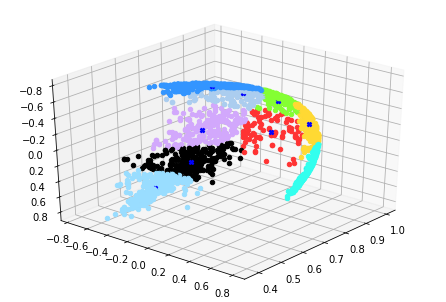

In [24]:
K = 9
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)